# 080 Curve Fitting with Scikit Learn

> COM6018

*Copyright &copy; 2023 Jon Barker, University of Sheffield. All rights reserved*.


## Introduction

In this lab we will be using linear regression to fit a model to the atmospheric gas concentration data that we have been working with in this module.

The lab assumes that you have read and understood the lecture notes, Curve Fitting with Scikit learn. We will be using ideas from these notes in the lab.


## Step 1 - Load the data

We will start by loading the data from the file `co2.csv` into a Pandas DataFrame. The data is in the same format as the data we used in the previous lab. 

You can use the `read_csv` method. The file contains comment lines that start with '%' so you will need to use the `comment` parameter of the `read_csv` method to ignore these lines.

Read the data such that the DataFrame columns are called 'year', 'month', 'day' and 'co2'. The csv file also contains columns called 'NB' and 'scale' but we will ignore these. You can use the `drop` method to remove these columns from the DataFrame. Store the DataFrame in a variable called `co2_df`.

Write the code below.


In [2]:
# SOLUTION

import pandas as pd
co2_df = pd.read_csv('data/co2.csv', comment='%', names=['year','month','day','co2','NB','scale'], skipinitialspace=True)

co2_df = co2_df.drop(['NB', 'scale'], axis=1)


## Step 2 - Prepare the data

We need to clean the data a little before we use it. For some of the rows the `co2` value is missing and the file contains a `NaN` value. We want to drop all of these rows from the DataFrame. We have done this in previous labs, so look back at your notes if you need to.

We also want to convert the year, month and day columns into a single column which we will call `decimal_year` which is the year plus the fraction of the year. For example, 1st January 2019 would be 2019.0 and 1st July 2019 would be 2019.5. We will later use this column as the x-axis when we plot the data. Think carefully to work out the formula for combining the year, month and day to make this value. 

(Note, you can cheat a little and pretend that each month is 1/12 of a year. This is not exactly correct but it will be close enough for our purposes.)

Write the code for these two steps in the cell below and run the test cell to check your code.

In [3]:
# SOLUTION

co2_df = co2_df[~co2_df.co2.isna()]

co2_df['decimal_year'] = co2_df.year + (co2_df.month - 1) / 12 + (co2_df.day - 1) / 365

print(co2_df.shape)

(17685, 5)


In [4]:
# TEST

assert co2_df.shape == (17685, 5), "The dataframe has the wrong shape"
assert set(co2_df.columns) == {'year', 'month', 'day', 'co2', 'decimal_year'}, "The dataframe has the wrong columns"
print('All tests passed!')

All tests passed!


## Step 3 - Plotting the data

We will now make a simple plot of the CO<sub>2</sub> concentration versus the decimal year. We can use the DataFrame's `plot` method to do this. Set the `x` and `y` parameters to the column names of the DataFrame that you want to plot. You can use the `figsize` parameter to make the plot bigger. A size of 10 by 6 should be suitable.

Write the line of code in the cell below and run it to produce the plot.

<Axes: xlabel='decimal_year'>

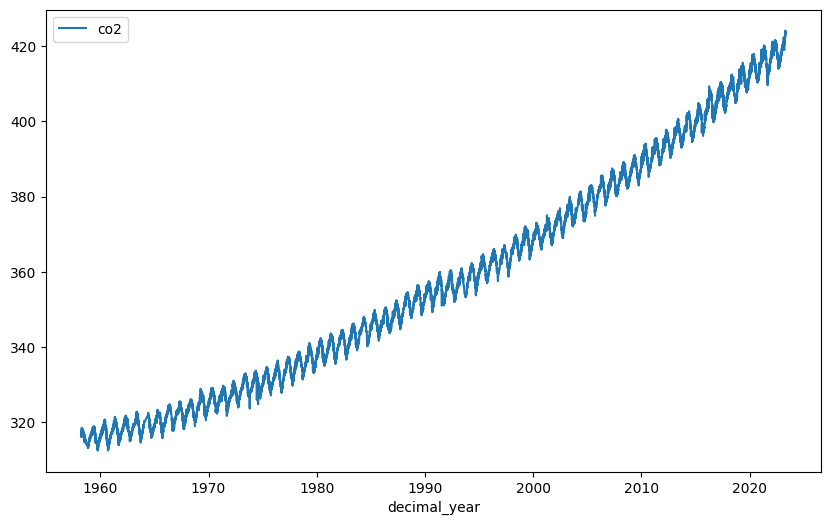

In [5]:
# SOLUTION 

co2_df.plot(x='decimal_year', y='co2', figsize=(10, 6))

This should produce the famous 'Keeling curve'. You will see that the carbon dioxide concentration has been increasing steadily since the earliest date in the data and also that there is a seasonal variation, i.e., the curve has a periodic fluctuation with a period of one year.

We are going to start by using a low order polynomial to fit the basic curve and we will then introduce periodic terms to model the seasonal fluctuations. Once we have fitting the model, we will use it to try and predict the date that the CO<sub>2</sub> concentration will first reach 450 ppm. 

## Step 4 - Fitting a polynomial curve using scikit-learn

### Step 4.1 - Fitting a straight line

We will start by fitting a straight line to the data using the `LinearRegression` class from `sklearn.linear_model`. 

Import `LinearRegression` from `sklearn.linear_model` and make an instance of the class which you can call `model`.  We will then use the `model.fit` method. The first parameter should be the `decimal_year` values (i.e., the x-axis values) and the second parameter should be the `co2` values (i.e., the y-axis values). You can get these from the DataFrame. 

An important detail: the fit method requires that the x-axis values are passed as a 2-D array, i.e., you need to ensure that the shape of the `decimal_year` array is `(n,1)` rather than `(n,)`. You can do this using the NumPy `reshape` method or the `expand_dims` method. See the lecture notes for an example of how to do this.

After calling the fit method, you can use the model to predict CO<sub>2</sub> concentrations by calling the `predict` method and passing the `decimal_year` values. Store the result in a variable called `co2_predicted`.

Then make a plot of the original `co2` values and the `co2_predicted` values plotted against the date. Plot these on the same axis so that you can compare the straight line fit with the actual values.


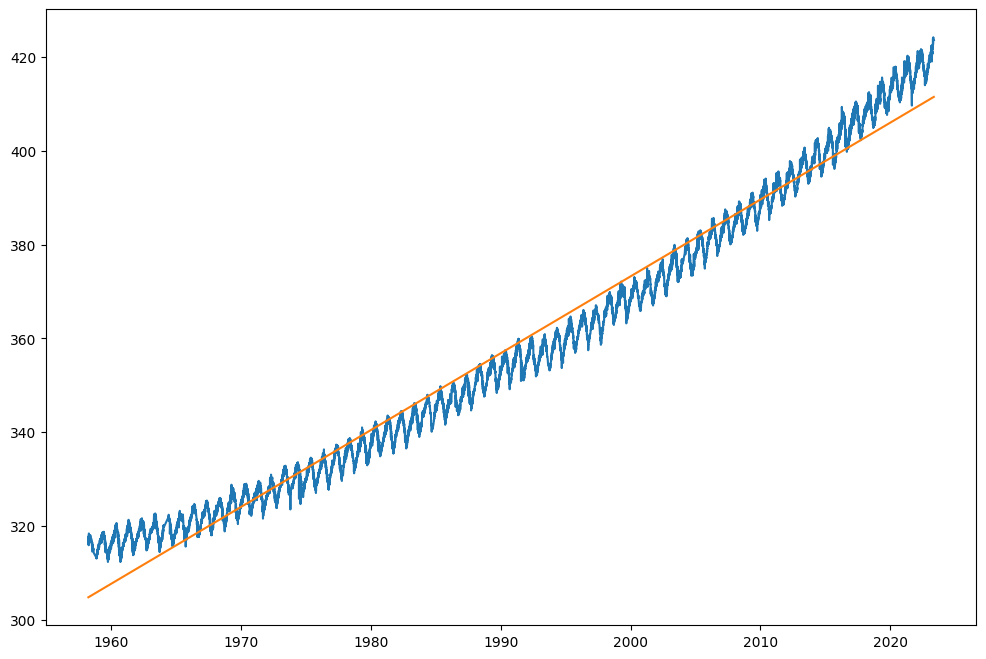

In [90]:
# SOLUTION

import matplotlib
from sklearn.linear_model import LinearRegression
co2 = co2_df['co2'].array
date = co2_df['decimal_year'].array.reshape(-1,1)
model = LinearRegression()
model.fit(date, co2)
co2_predicted = model.predict(date)

plt.figure(figsize=(12, 8))
plt.plot(date, co2, label='CO2 concentration')
plt.plot(date, co2_predicted, label='CO2 concentration')

If you have done everything correctly, you should see that the straight line is a reasonable fit to the data except that it does not capture the period component, and that it is too steep in the 1960s and not steep enough in the 2000s and 2010s. The pace of the CO<sub>2</sub> concentration increase has been increasing over time. 

We can make a better fit using a higher order polynomial with $x^2$ and $x^3$ terms. We will do this in the next step.

### Step 4.2 - Fitting a polynomial curve

We will now fit a polynomial curve to the data. We will use the `PolynomialFeatures` class from `sklearn.preprocessing` to generate the polynomial features. We will then use the `LinearRegression` class to fit the model.

Import `PolynomialFeatures` and `LinearRegression` from `sklearn.preprocessing` and `sklearn.linear_model` respectively. Make an instance of the `PolynomialFeatures` class and call it `poly`. Set the `degree` parameter to 3. Pass the `decimal_year` values to the `poly.fit_transform` method and store the result in a variable called `X`. (We will use a capital X to emphasise that this is a matrix, but note, in general, variables starting with capital letters should only be used for the names of classes).

The `poly.fit_transform` method returns a matrix with 4 columns. The first column is the constant term, the second column is the $x^1$ term, the third column is the $x^2$ term and the fourth column is the $x^3$ term. We will use this matrix as the input to the `LinearRegression` `fit` method.

Make an instance of the `LinearRegression` class and call it `model`. Call the `model.fit` method and pass the `X` matrix and the `co2` values, just as you did in the previous step.

Now we can call `model.predict` and pass the `X` matrix again to get the predicted CO<sub>2</sub> concentration values. Store the result in a variable called `co2_predicted`.

Make a plot of the original `co2` values and the `co2_predicted` values plotted against `date`. Plot these on the same axis so that you can compare the straight line fit with the actual values.


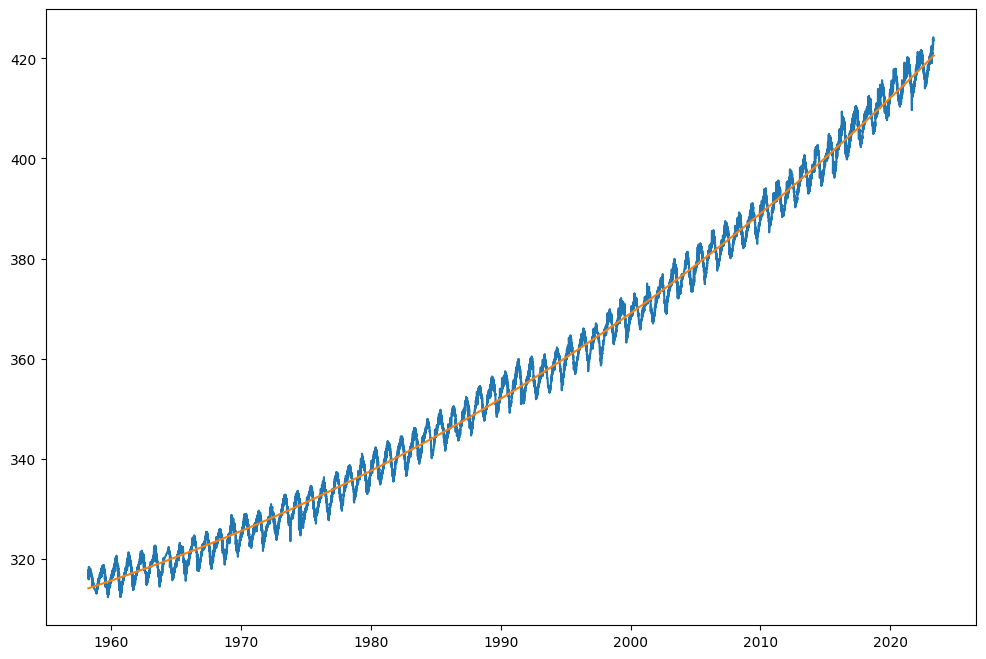

In [10]:
# SOLUTION

import matplotlib
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(degree=3)
co2 = co2_df['co2'].array
date = co2_df['decimal_year'].array.reshape(-1,1)
X = poly.fit_transform(date)
model = LinearRegression()
model.fit(X, co2)
co2_predicted = model.predict(X)

plt.figure(figsize=(12, 8))
plt.plot(date, co2, label='CO2 concentration')
plt.plot(date, co2_predicted, label='CO2 concentration')

You can see that the curve fits much better to the data.

We can quantify the goodness of the fit by computing the root mean squared error (RMSE) between the predicted CO<sub>2</sub> values and the actual ones.

We can do this easily by using the `mean_squared_error` function from `sklearn.metrics`. Import this function and then call it passing the `co2` values and the `co2_predicted values`. By default, this function returns the mean squared error (MSE). To get the RMSE value you need to also pass the parameter `squared=False`. 

Store the result in a variable called `rmse`. Print the value of `rmse`.

In [13]:
# SOLUTION

from sklearn.metrics import mean_squared_error

rmse = mean_squared_error(co2, co2_predicted, squared=False)
print(f'RMSE: {rmse:.2f}')

RMSE: 2.26


### Step 4.3 - Finding the best polynomial degree

In the previous section, we used a polynomial of degree 3. We did this by passing the parameter `degree=3` to the `PolynomialFeatures` constructor. We can try different values of the degree parameter to see which gives the best fit.

In the cell below, use a loop to try values of `degree` from 1 to 10. For each value of `degree`, compute the RMSE and print it. You should be able to implement this quickly by cutting and pasting the code from the previous cells and then adding a loop around it.


In [16]:
# SOLUTION

from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

co2 = co2_df['co2'].array
date = co2_df['decimal_year'].array.reshape(-1,1)

for degree in range(1, 11):
    poly = PolynomialFeatures(degree=degree)
    X = poly.fit_transform(date)
    model = LinearRegression()
    model.fit(X, co2)
    co2_predicted = model.predict(X)

    rmse = mean_squared_error(co2, co2_predicted, squared=False)
    print(f'Degree: {degree}, RMSE: {rmse:.2f}')

Degree: 1, RMSE: 4.73
Degree: 2, RMSE: 2.27
Degree: 3, RMSE: 2.26
Degree: 4, RMSE: 2.26
Degree: 5, RMSE: 2.26
Degree: 6, RMSE: 2.26
Degree: 7, RMSE: 2.26
Degree: 8, RMSE: 2.26
Degree: 9, RMSE: 2.26
Degree: 10, RMSE: 2.26


You should find that the error drops a lot going from degree 1 to degree 2, but then only drops a little bit more going from degree 2 to degree 3. After that, the error does not drop much at all. This suggests that degree 2 or degree 3 (i.e., a 2nd or 3rd order polynomial) is the best choice.

### Step 4.4 - A fairer methodology for model evaluation

In the above, we tested our model by comparing the predictions against the actual values, but we made predictions at the same dates as were used when fitting the model. This is not a fair test because the model has already seen these data points and so it is not surprising that it fits them well. For our model to be useful, we need it to work well when predicting values for dates that it has not seen before. So to test how well we can do this, we want to fit the data using a subset of the dates (e.g., for dates up to 2000) and then test the model by predicting the values for the dates that were not used for fitting (e.g., from 2000 to 2019).

The easiest way to do this is to split our `co2` and `date` data into two parts which we might call `co2_train` and `date_train` for the years up to 2000 and `co2_test` and `date_test` for the years from 2000 to 2019. We can then fit the model using the `co2_train` and `date_train` data and then test the model by predicting the CO<sub>2</sub> concentration values for the dates in `date_test`. We can then compare these predicted values with the actual values stored in `co2_test`.

We will first split the data. This can be done using the code below.

In [25]:
co2 = co2_df['co2'].array
date = co2_df['decimal_year'].array

date_train = date[date < 2000].reshape(-1,1)
date_test = date[date >= 2000].reshape(-1,1)
co2_train = co2[date < 2000]
co2_test = co2[date >= 2000]

Now rewrite the code from the previous section that used a loop to compute RMSE value for polynomials of order N. But substitute `date` and `co2` with the `date_train`, `date_test` and `co2_train`, `co2_test` values as appropriate. Note, you will also need to make separate `X_train` and `X_test` matrices using the `date_train` and `date_test` values.

Degree: 1, RMSE: 14.29
Degree: 2, RMSE: 2.57
Degree: 3, RMSE: 15.53
Degree: 4, RMSE: 15.72
Degree: 5, RMSE: 15.91
Degree: 6, RMSE: 16.11
Degree: 7, RMSE: 16.31
Degree: 8, RMSE: 16.51
Degree: 9, RMSE: 16.72
Degree: 10, RMSE: 16.93


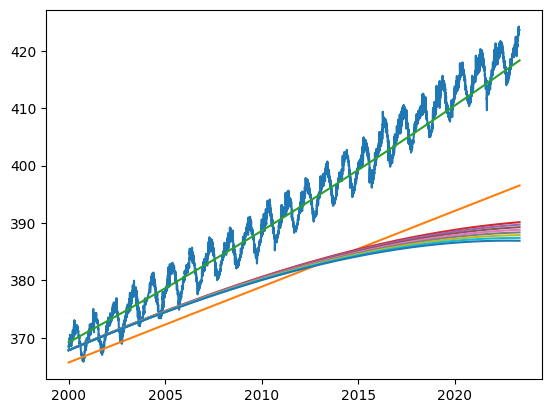

In [28]:
# SOLUTION

import matplotlib
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures


plt.plot(date_test, co2_test, label=f'Degree {degree}')

for degree in range(1, 11):
    poly = PolynomialFeatures(degree=degree)
    X_train = poly.fit_transform(date_train)
    X_test = poly.fit_transform(date_test)
    model = LinearRegression()
    model.fit(X_train, co2_train)
    co2_predicted = model.predict(X_test)
    plt.plot(date_test, co2_predicted, label=f'Degree {degree}')
    rmse = mean_squared_error(co2_test, co2_predicted, squared=False)
    print(f'Degree: {degree}, RMSE: {rmse:.2f}')

Using this more rigorous methodology, you should find that the best polynomial order is 2 rather than 3. With order 3 the predictions become quite poor. This is a case of overfitting. The model with order 3 is too complex and it fits local variability in the training data that does not reflect the underlying trend.


### Step 5 - Modeling the periodic component

We will now improve our model by adding periodic terms. In the lecture notes, we saw examples of how to do this by summing sine and cosine terms. For this to work, we have to assume we know the period of the periodic component. In this case we know that the period is one year.

Our model is going to combine the polynomial terms with the periodic terms. So it will have the form,

$y = a + p_1 x + p_2 x^2 + ... + p_n x^{N_\alpha} + s_1 *sin(1 \times 2 \pi x) + c_1 *cos(1 \times 2 \pi x) + ... + s_n * sin (N_\beta \times 2 \pi x) + c_n * cos (N_\beta \times 2 \pi x)$

where $x$ is the date in years and $y$ is the CO<sub>2</sub> concentration. In the above equation, $N_\alpha$ is the order of the polynomial and $N_\beta$ is the number of periodic terms, and $a$, $p_1$, $p_2$, ..., $p_n$, $s_1$, $c_1$, ..., $s_n$, $c_n$ are the parameters that we need to estimate.

To fit this model we will need to store the functions $x$, $x^2$, ..., $x^N$, and $sin(1 \times 2 \pi x)$, $cos(1 \times 2 \pi x)$, ..., $sin(n \times 2 \pi x)$, $cos(n \times 2 \pi x)$ in the matrix $X$. We will then use the `LinearRegression` class to fit the model in exactly the same way as we did in the previous section.

Making the `X` with the polynomial terms is easy. We just use the `PolynomialFeatures` class as we did before. But there is no equivalent function for making the periodic terms -- we need to make those using the NumPy sine and cosine functions and append them to the `X` matrix. See the lecture notes for an example.

### Step 5.1 - Making the X matrix

In the cell below write a function called `make_features` to make the `X` matrix for the model above. The function should take the $x$ values (i.e., the `decimal_year` values) and the order of the polynomial and the number of periodic terms as parameters. Call the parameters `x`, `order_polynomial` and `order_periodic` respectively. It should return the $X$ matrix. 

The function can use the `PolynomialFeatures` class to make the polynomial terms and then append the periodic terms to the matrix. Or it may be clearer to just make both the polynomial and periodic terms using NumPy functions.

When you have written the function, run the test cell to check that it works.

In [64]:
# SOLUTION

def make_features(x, order_polynomial, order_periodic):

    X = np.ones((len(x), 1))
    for i in range(1, order_polynomial + 1):
        X = np.concatenate([X, x ** i], axis=1)
    for i in range(1, order_periodic + 1):
        X = np.concatenate([X, np.sin(2 * np.pi * i * x), np.cos(2 * np.pi * i * x)], axis=1)
    return X


In [65]:
# TEST 
x = np.linspace(0, 1, 10).reshape(-1, 1)
assert make_features(x, 2, 0).shape == (10, 3)
assert make_features(x, 0, 2).shape == (10, 5)
assert make_features(x, 2, 2).shape == (10, 7)
print('All tests passed!')

All tests passed!


Now use your function to make the feature matrix `X_train` for a model with polynomial order 2 and periodic order 1, i.e., by passing the model the `date_train` values that you used earlier.  

Then make a `LinearRegression` model and call its `fit` method passing `X_train` and `co2_train`.

Finally, call `model.predict` with the `X_train` values to get the predicted CO<sub>2</sub> concentration values. Store the result in a variable called `co2_predicted` and plot the `co2_predicted` and `co2_train` values against the `date_train` values. You should see that the model fits the data well.


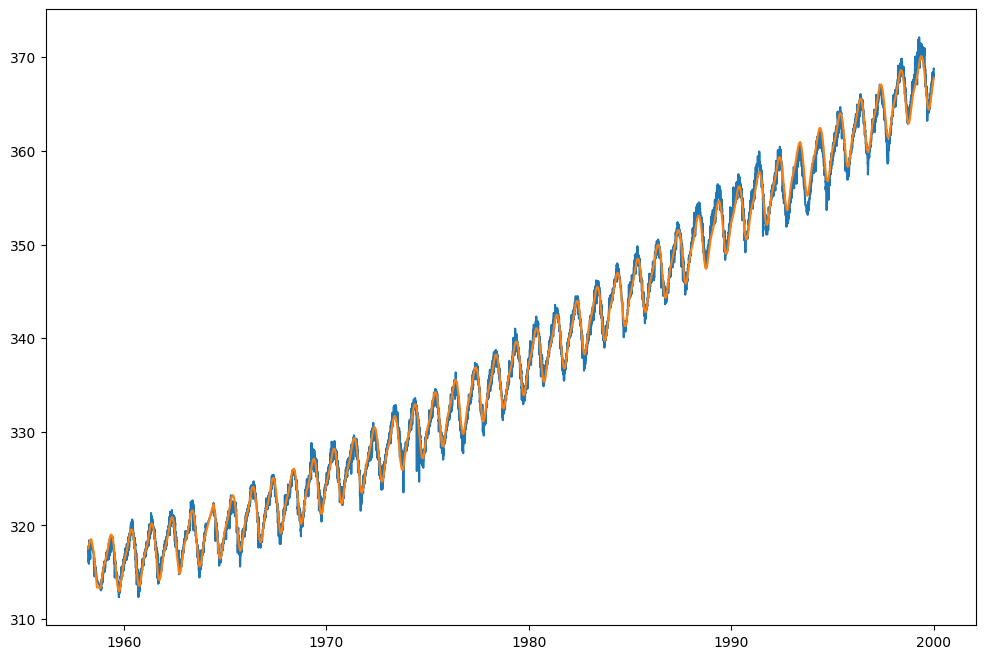

In [70]:
# SOLUTION

import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

co2 = co2_df['co2'].array
date = co2_df['decimal_year'].array.reshape(-1,1)
X_train = make_features(date_train, order_polynomial=3, order_periodic=3)
model = LinearRegression()
model.fit(X_train, co2_train)
co2_predicted = model.predict(X_train)

plt.figure(figsize=(12, 8))
plt.plot(date_train, co2_train, label='CO2 concentration')
plt.plot(date_train, co2_predicted, label='CO2 concentration')

You can play with the `periodic_order` to see how it affects the fit. In the next section, we will try to find the best value for the `periodic_order` using the same methodology that we used to find the best value for the `polynomial_order`.

### Step 5.2 - Finding the best value for the periodic order

We will now use the same methodology that we used to find the best value for the polynomial order to find the best value for the periodic order. 

We will fix the polynomial order at the value of 2 but try periodic orders from 0 to 10. In each case we will fit the model using the `date_train` and `co2_train` values and then test the model by predicting the CO<sub>2</sub> concentration values for the `date_test` values. We will compute the RMSE value for each value of the periodic order and print it to see which works best.

You should be able to do all of this using code from the previous sections. 

Implement your solution in the cell below.


In [74]:
# SOLUTION

import matplotlib
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures


for degree in range(0, 11):
    X_train = make_features(date_train, order_polynomial=2, order_periodic=degree)
    X_test = make_features(date_test, order_polynomial=2, order_periodic=degree)
    model = LinearRegression()
    model.fit(X_train, co2_train)
    co2_predicted = model.predict(X_test)
    rmse = mean_squared_error(co2_test, co2_predicted, squared=False)
    print(f'Degree: {degree}, RMSE: {rmse:.2f}')

Degree: 0, RMSE: 2.57
Degree: 1, RMSE: 1.21
Degree: 2, RMSE: 1.07
Degree: 3, RMSE: 1.08
Degree: 4, RMSE: 1.08
Degree: 5, RMSE: 1.08
Degree: 6, RMSE: 1.08
Degree: 7, RMSE: 1.08
Degree: 8, RMSE: 1.08
Degree: 9, RMSE: 1.08
Degree: 10, RMSE: 1.08


You should find that the RMSE error with the periodic order set to 0 (i.e. the purely polynomial model) is about 2.57.  For the periodic order set to 1 (i.e. adding in just a simple sinusoidal variation),  it falls to about 1.21. Increasing to order 2 (i.e., adding in a second sinusoidal term) it falls a bit further to about 1.07. After that, the prediction start to get worse again, i.e., the model starts overfitting the data. 

So, we will conclude that the best model to use is the one with polynomial order 2 and periodic order 2.

## Step 6 - Using our model to predict the future

We will now use our model to predict the date when the CO<sub>2</sub> concentration will first reach 450 ppm. 

We will use the model of polynomial order 2 and periodic order 2 that we found was the best fit in the previous section.  We will re-estimate the model parameters using all the data (i.e., the date and CO<sub>2</sub> concentration values from 1958 to 2019). We will then use the model to predict CO<sub>2</sub> concentration levels up to the year 2040 and look to see when this value first reaches 450 ppm.

### Step 6.1 - Re-estimating the model parameters

We will first re-estimate the model parameters using all the data. This is easy to do. We just need to make the X matrix using all the dates (i.e., passing `date` to our `make_features` function). We then construct a new `LinearRegression` model and finally, we call the `fit` method on the model.

Implement this in the cell below and run the test function that will check that your model has the correct number of parameters, (i.e., 7)

In [77]:
# SOLUTION

X = make_features(date, order_polynomial=2, order_periodic=2)
model = LinearRegression()
model.fit(X, co2)


LinearRegression()

In [81]:
# TEST

assert model.coef_.shape == (7,), "The model has the wrong number of coefficients"
print('All tests passed!')

All tests passed!


### Step 6.2 - Predicting the future

Now make a new date axis with dates that run all the way from 2000 to 2040.

You can do this using `np.linspace` to generate the date values. Choose a resolution of about 0.01 years, i.e., 100 values per year. Call this date axis `date_predict`.

Then pass this date axis to your `make_features` function to make the corresponding `X` matrix. 

Then pass the `X` matrix to the `model.predict` method to get the predicted CO<sub>2</sub> concentration values. Store the result in a variable called `co2_predicted`.

Finally, plot the `co2_predicted` values against your date axis. 


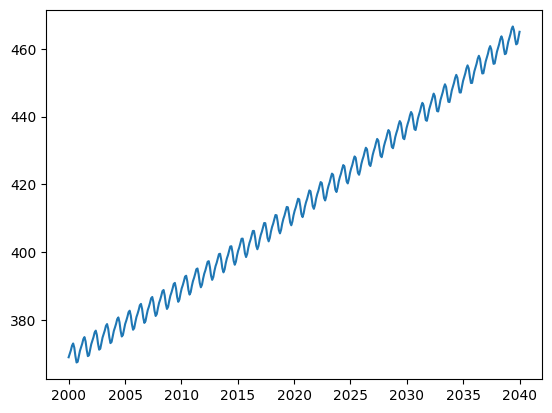

In [84]:
date_predict = np.linspace(2000, 2040, 400).reshape(-1, 1)
X_predict = make_features(date_predict, order_polynomial=2, order_periodic=2)
co2_predicted = model.predict(X_predict)
plt.plot(date_predict, co2_predicted)

You can now find the earliest data at which the CO<sub>2</sub> concentration is predicted to exceed 450 ppm using something like,

```
np.min(date_predict[co2_predicted > 450])
```

alternatively, you can ask for the last date at which the CO<sub>2</sub> concentration is predicted to fall below 450 ppm using something like

```
np.max(date_predict[co2_predicted < 450])
```

These dates are a little different due to the annual fluctuations in the CO<sub>2</sub> concentration.

You can compare your estimate with that made by other data scientists. There are many predictions that can be found with a bit of searching on the web. For example, the following page has a prediction of 2037.

https://insight.factset.com/atmospheric-carbon-levels-may-2023-update#:~:text=The%20resulting%2014.3%20tells%20us,global%20warming%20are%20reached%3A%202037.

What we have to remember is that these are just predictions and that the future is uncertain. Our predictions have been made by modelling the past 60 years of data and extrapolating. This is making the big assumption that growth will continue on the same trajectory as it has in the past. Clearly though, this is not necessarily the case. For example, as the dangers of CO<sub>2</sub> emissions become more apparent, governments are taking action to reduce emissions. This will (hopefully!) change the trajectory of the CO<sub>2</sub> concentration and so our model will no longer be valid and our predicted date wll be incorrect. If emissions were cut drastically, it could even be the case that concentrations start to fall and than 450 ppm is never reached. 

## Conclusion

In this lab, we have used linear regression to fit a model to the atmospheric CO<sub>2</sub> concentration data. We have seen how to use the `PolynomialFeatures` class to make polynomial features and how to use the `LinearRegression` class to fit a model. We have also seen how to use the `mean_squared_error` function to compute the RMSE value for a model. We used the RMSE value to tune the hyperparameter (i.e., finding the polynomial order that produced the smallest error). We then saw how to use the `np.sin` and `np.cos` functions to make periodic features. We used these to make a model that had both polynomial and periodic terms that could fit the data much better. We then tuned the hyperparameters by training on a subset of the data and testing the model's ability to predict the future. Finally, we used our model to predict the date when the CO<sub>2</sub> concentration will first reach 450 ppm.

In this lab, we have used the basic least means squares approach to fitting a model. This approach works well but can have some drawbacks. When the number of parameters is large, the model can become unstable and overfit the data. There are more sophisticated approaches that can be used to `regularise` the model and prevent overfitting. For example, ridge regression and lasso regression. These are implemented in the `Ridge` and `Lasso` classes in `sklearn.linear_model`. You can read about these in the Scikit Learn documentation.